## Installing necessary libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 300)
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pointbiserialr
import pingouin as pg
import matplotlib.pyplot as plt

/home/jupyter-apaddo/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Loading the merged dataframe

In [2]:
woundassessment=pd.read_csv("Final_Merged_DataFrame_June24.csv")
woundassessment=woundassessment.drop(["Unnamed: 0"],axis=1)
woundassessment=woundassessment.rename(columns={"Wound_Title":"WoundLocation"})
woundassessment.columns.tolist()
woundassessment=woundassessment.drop(["WoundID", "PatientID", "WoundNumber"],axis=1)
woundassessment['PatientIDWoundNumber'] = woundassessment['PatientIDWoundNumber'].astype(str).str.replace('\.0', '', regex=True)
woundassessment=woundassessment.drop_duplicates()
woundassessment=woundassessment.reset_index()
woundassessment=woundassessment.drop(["index"],axis=1)

/tmp/ipykernel_149724/3912794564.py:1: DtypeWarning: Columns (61,62,63,64,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,141,147,154) have mixed types. Specify dtype option on import or set low_memory=False.
  woundassessment=pd.read_csv("Final_Merged_DataFrame_June24.csv")


In [3]:
woundassessment["WoundLocation"]

0             Wound #1 Right, Plantar Foot
1             Wound #1 Right, Plantar Foot
2             Wound #1 Right, Plantar Foot
3             Wound #1 Right, Plantar Foot
4             Wound #1 Right, Plantar Foot
                        ...               
309061       Wound #2 Right, Plantar Foot 
309062       Wound #2 Right, Plantar Foot 
309063    Wound #3 Right, Posterior Ankle 
309064    Wound #3 Right, Posterior Ankle 
309065    Wound #3 Right, Posterior Ankle 
Name: WoundLocation, Length: 309066, dtype: object

In [4]:
# Correcting the Wound Location values
woundassessment['WoundLocation'] = woundassessment['WoundLocation'].str.split(', ').str[1].str.strip()
woundassessment["WoundLocation"]

0            Plantar Foot
1            Plantar Foot
2            Plantar Foot
3            Plantar Foot
4            Plantar Foot
               ...       
309061       Plantar Foot
309062       Plantar Foot
309063    Posterior Ankle
309064    Posterior Ankle
309065    Posterior Ankle
Name: WoundLocation, Length: 309066, dtype: object

## Dropping the 'ID' columns because we do not need those for classification and few columns which are not relevant to predict wound healing status

In [22]:
woundassessment=woundassessment.drop(["Woundassessment_UserID","patientmedications_DocumentType","patientmedications_VisitID",
                                      "patientmedications_UserID","Wound_DocumentType","Wound_UserID","Wound_PhysicianID", 
                                      "AdmissionID", "previousID", "SyncUserID","ReferringPhysicianID", "patientmedications_Title", 
                                      "patientmedications_PhysicianID", "Woundassessment_PhysicianID","Patient_UserID","PhysicianID",
                                      "Woundassessment_VisitID", "Notes", "imageFileCount", "Woundassessment_Title", 
                                      "Woundassessment_DocumentType"], axis=1)
woundassessment

,Pulse,AdherentYellowSlough,AdiposeExposed,AdiposeNecrosisExposed,area,AtrophieBlanche,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,TInsuranceZip,PInsuranceZip,Diabetes
0,NaN,NaN,1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,...,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,-1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,...,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,-1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,...,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,...,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309061,NaN,NaN,1.0,1.0,93.7,1.0,1.0,1.0,1.0,1.0,...,NaN,10210112_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309062,NaN,NaN,1.0,1.0,46.0,1.0,1.0,1.0,1.0,1.0,...,NaN,10210112_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309063,NaN,NaN,1.0,1.0,81.0,1.0,1.0,1.0,1.0,1.0,...,NaN,10210112_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309064,NaN,NaN,1.0,1.0,67.0,1.0,1.0,1.0,1.0,1.0,...,NaN,10210112_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check which columns have how many non-null values

In [23]:
# Get the number of non-null values in each column
non_null_counts = woundassessment.count()

# Get the number of null values in each column
null_counts = woundassessment.isnull().sum()

# Output the counts
print("Non-null counts:")
#print(non_null_counts)
#print("\nNull counts:")
#print(null_counts)

non_null_counts

Non-null counts:


Pulse                                     71072
AdherentYellowSlough                       2176
AdiposeExposed                           303691
AdiposeNecrosisExposed                   303662
area                                     258097
AtrophieBlanche                          303692
BoneNecrosisExposed                      303662
BrawnyInduration                         303692
Callus                                   303692
CapsuleExposed                           303663
CapsuleNecrosisExposed                   303662
color                                    207881
CompCompression                          175054
CompDiet                                 284040
CompDressing                             284040
CompExercise                             284040
CompHBOVisits                            284039
CompLimb                                 284040
CompMedication                           284040
CompOffLoad                              284040
CompSmoking                             

## Drop those columns which have less than 5000 non-values

In [24]:
woundassessment = woundassessment.dropna(axis=1, thresh=5000)
woundassessment

,Pulse,AdiposeExposed,AdiposeNecrosisExposed,area,AtrophieBlanche,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,CapsuleNecrosisExposed,...,BMI,SmokingStatus,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip
0,NaN,1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,1.0,...,27.5,3.0,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN
1,NaN,-1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,1.0,...,27.5,3.0,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN
2,NaN,-1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,27.5,3.0,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN
3,NaN,-1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,1.0,...,27.5,3.0,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN
4,NaN,-1.0,1.0,400.0,1.0,1.0,1.0,1.0,1.0,1.0,...,27.5,3.0,quit 1992,5978401_1,7.0,79.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309061,NaN,1.0,1.0,93.7,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,10210112_2,NaN,NaN,NaN,NaN,NaN,NaN
309062,NaN,1.0,1.0,46.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,10210112_2,NaN,NaN,NaN,NaN,NaN,NaN
309063,NaN,1.0,1.0,81.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,10210112_3,NaN,NaN,NaN,NaN,NaN,NaN
309064,NaN,1.0,1.0,67.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,10210112_3,NaN,NaN,NaN,NaN,NaN,NaN


## See how many unique wounds are there for which we want to do the classification and sort the dataframe based on the WoundNumber

In [25]:
display(woundassessment["PatientIDWoundNumber"].nunique())
sorted_df = woundassessment.sort_values('PatientIDWoundNumber')

25255

## See how many unique patients are there for whom we want to do the classification

In [26]:
sorted_df["PatientIDWoundNumber"].str.split('_').str[0].nunique()

8728

#### We want to have a processed dataframe for the classification but in this dataframe there are a lot of data elements, so we want to keep only those data elements which are necessary/important for the classification models. Thus we need to do the feature importance, thus we are adding new column in this "wound healing status", using that as target variable, we will try to compute feature importance value for each data elements and based on that, we will remove the data elements before doing the transpose.

In [ ]:
big_df=pd.DataFrame()


sorted_df=sorted_df[sorted_df.DateAdded_woundassessment.notnull()]
#sorted_df["area"]=sorted_df["area"].replace(0,0.00001)

unique_wounds=sorted_df["PatientIDWoundNumber"].unique().tolist()
for i in range(len(unique_wounds)):
#     if i>500:
#         break
    print(i)
    
    wound=unique_wounds[i]
    df_wound=sorted_df.query("PatientIDWoundNumber==@wound")
    #df_wound=df_wound[["PatientIDWoundNumber","DateAdded_woundassessment","area"]]
    df_wound=df_wound.drop_duplicates()
    df_wound=df_wound[df_wound.area.notnull()]

    
    # Convert 'DateAdded_woundassessment' column to datetime type
    df_wound['DateAdded_woundassessment'] = pd.to_datetime(df_wound['DateAdded_woundassessment'])

    # Keep the maximum value in 'area' for each date
    df_wound = df_wound.loc[df_wound.groupby('DateAdded_woundassessment')['area'].idxmax()]

    df_wound=df_wound.sort_values('DateAdded_woundassessment')
    
    df_wound["Wound_healing_status"]=np.nan
    df_wound["Wound_healing_percentage"]=np.nan

    
    df_wound=df_wound.reset_index()
    df_wound=df_wound.drop(["index"],axis=1)
    
    for j in range(df_wound.shape[0]):
        if j == 0:
            df_wound["Wound_healing_status"][j]='Unknown'
        else:
            percentage=(df_wound["area"][j-1]-df_wound["area"][j])/df_wound["area"][j-1]*100
            df_wound["Wound_healing_percentage"][j]= percentage

            if percentage == 100:
                df_wound["Wound_healing_status"][j]= 'Healed'
            elif percentage>=65:
                df_wound["Wound_healing_status"][j]= 'Healing'
            elif (percentage<65) & (percentage>=20):
                df_wound["Wound_healing_status"][j]= 'Grey'
            else:
                df_wound["Wound_healing_status"][j]= 'Not healing'
    
    # Convert the 'Date' column to datetime
    df_wound['DateAdded_woundassessment'] = pd.to_datetime(df_wound['DateAdded_woundassessment'])

    # Find the minimum date in the DataFrame
    first_date = df_wound['DateAdded_woundassessment'].min()

    # Calculate the day differences relative to the first date
    df_wound['DayNumber'] = (df_wound['DateAdded_woundassessment'] - first_date).dt.days + 1
    
    
    big_df = pd.concat([big_df, df_wound], axis=0)

    #display(df_wound)
#sorted_df[["PatientIDWoundNumber","DateAdded_woundassessment","area"]].head(50)

In [32]:
big_df["Wound_healing_status"].unique()

array(['Unknown', 'Not healing', 'Grey', 'Healing', 'Healed'],
      dtype=object)

## We do not need the wound healing percentage column, thus we will remove that.

In [ ]:
big_df=big_df.drop(["Wound_healing_percentage"], axis=1)

## Save the dataframe

In [30]:
big_df.to_csv("big_df.csv")

In [55]:
big_df=pd.read_csv("big_df.csv")
big_df=big_df.drop(["Unnamed: 0"],axis=1)
big_df

/tmp/ipykernel_108345/3784010270.py:1: DtypeWarning: Columns (55,56,57,58,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,127) have mixed types. Specify dtype option on import or set low_memory=False.
  big_df=pd.read_csv("big_df.csv")


,Pulse,AdiposeExposed,AdiposeNecrosisExposed,area,AtrophieBlanche,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,CapsuleNecrosisExposed,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip,Wound_healing_status,DayNumber
0,NaN,-1.0,1.0,33.60,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Unknown,1
1,NaN,-1.0,1.0,38.00,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Not healing,8
2,NaN,-1.0,1.0,40.28,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Not healing,15
3,NaN,-1.0,1.0,40.28,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Not healing,22
4,NaN,-1.0,1.0,30.00,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Grey,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197470,NaN,1.0,1.0,169.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Not healing,72
197471,NaN,1.0,1.0,130.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Grey,75
197472,NaN,1.0,1.0,110.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Not healing,80
197473,NaN,1.0,1.0,110.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Not healing,87


## Check the datatype 

In [56]:
big_df.dtypes

Pulse                                    float64
AdiposeExposed                           float64
AdiposeNecrosisExposed                   float64
area                                     float64
AtrophieBlanche                          float64
BoneNecrosisExposed                      float64
BrawnyInduration                         float64
Callus                                   float64
CapsuleExposed                           float64
CapsuleNecrosisExposed                   float64
color                                    float64
CompCompression                          float64
CompDiet                                 float64
CompDressing                             float64
CompExercise                             float64
CompHBOVisits                            float64
CompLimb                                 float64
CompMedication                           float64
CompOffLoad                              float64
CompSmoking                              float64
CompWoundVisits     

## Change the datatype of the categorical values

In [57]:
# categorical_features = [
#     'color', 'CompCompression', 'CompDiet', 'CompDressing', 'CompExercise',
#     'CompHBOVisits', 'CompLimb', 'CompMedication', 'CompOffLoad', 'CompSmoking',
#     'CompWoundVisits', 'ExudateAmount', 'imageFileCount', 'lowerExtremityEdema',
#     'NurseOnlyVisit', 'Odor', 'Pain', 'Stage', 'surroundingSkin',
#     'surroundingSkinColor', 'SystematicInfection', 'WoundMargin', 'eschar',
#     'AccidentType', 'acquiredAtFacility', 'ActiveWound', 'Anterior_Posterior',
#     'Anterior_Dorsal', 'ClusteredWound', 'Inferior_Superior', 'Left_Right',
#     'Location', 'PendingAmputationOnPresentation', 'Proximal_Distal',
#     'ResolvedRecurrence', 'ResultOfAccident', 'Type', 'WoundCondition',
#     'WoundRecurrence', 'woundstatus', 'WoundLocation', 'AdmissionStatusCode',
#     'MedicareAdmission', 'PalliativeCare', 'CauseOfDeath', 'ethnicityCdcCode',
#     'patientEthnicity', 'PatientGender', 'PatientSelfCare', 'Religion',
#     'SmokingStatus', 'SmokingStatusText', 'DebridementLevel', 'Method',
#     'Bleeding', 'IsThisBurn', 'SInsuranceZip', 'PInsuranceZip',
#     'Wound_healing_status'
# ]


categorical_features = ['Method', 'SmokingStatus', 'NonWoundDiagnosis', 'PatientGender','MedicareAdmission', 
                        'SmokingStatusText', 'WoundCondition', 'Location','AdmissionStatusCode', 'Religion',
                        'Pain', 'GranulationTexture','ExudateAmount', 'NormalColor', 'PalliativeCare', 
                        'Patient_RiskLevel', 'color', 'Exudate', 'Type', 'RedGranulation', 'Left_Right', 
                        'PatientDOB', 'WoundMargin', 'tunneling', 'RaceCodeList', 'PatientSelfCare', 
                        'PInsuranceZip', 'Bleeding', 'surroundingSkin', 'surroundingSkinColor', 'Anterior_Dorsal',
                        'CauseOfDeath', 'Proximal_Distal', 'woundstatus', 'ActiveWound', 'Inferior_Superior', 
                        'normalTexture', 'ResolvedRecurrence', 'Stage', 'slough', 'IsThisBurn', 'woundProgress', 
                        'Notes', 'CompCompression', 'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar', 
                        'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture','ResolvedRecurrence',
                        'Stage', 'IsThisBurn', 'CompCompression', 'SloughLessThan20', 'Anterior_Posterior', 'Odor',
                        'eschar','TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
                        'ResolvedRecurrence','FinalVisit_Healing_Status','PatientZIP', 'AllVisit_woundProgress', 
                        "Wound_healing_status", "AccidentType", "SInsuranceZip", "AdiposeExposed", "Rash",
                        "ethnicityCdcCode","CompDiet","Excoriation","AtrophieBlanche","Denuded", "Fluctuance",
                        "Moist", "NormalMoisture", "Shiny","Erythema","SSCAndSPending", "SSSignsAndSymptoms", 
                        "sinustract", "pinkgran", "greygran", "Crepitus", "Rubor", "SystematicInfection", "Callus",
                        "DryScaly", "ResultOfAccident", "Induration", "NoMeasurableDepth", "SSConfirmedLocal", 
                        "TendonNecrosisExposed", "Edema", "Friable", "BrawnyInduration", "Ecchymosis", 
                        "SSSystemicAntibiotics", "Ecchymosis", "ExposedMuscle", "Maceration", "Hemosiderosis", 
                        "redgran", "Scarring","AdiposeNecrosisExposed", "ExposedTendon","DebridementLevel",
                        "Temperature", "AdiposeExposed", "BoneNecrosisExposed", "CapsuleExposed", 
                        "CapsuleNecrosisExposed", "CompDressing", "CompExercise", "CompHBOVisits", "CompLimb",
                        "CompMedication", "CompOffLoad", "CompSmoking", "CompWoundVisits", "Cyanosis", 
                        "ExposedBone", "GranulatedHyperGranulated", "hypergran", "lowerExtremityEdema", 
                        "MuscleNecrosisExposed", "NonGranulationBiofilm", "NonGranulationDessicated", 
                        "NurseOnlyVisit", "Pallor", "SSAbscess", "SSChangesInGranulationTissue",
                        'SSConfirmedSystemic', 'SSDrainageDisproportionate', 'SSDrainageThick', 'SSFever',
                        'SSFoulWoundOdor', 'SSIncreasedEdema', 'SSInflammationExtendingToBone', 'SSMalaise', 
                        'SSNewOnset', 'SSOther', 'SSPocketing', 'SSPoorlyDefinedErythemalBorder', 
                        'SSTopicalAntibiotics', 'SSWarmthExtendingBeyondLocalPeriWound', 'SSWoundStalling', 
                        'JointNecrosisExposed', 'Bogginess', 'ExposedJoint', 'DryEscharFluctance', 
                        "acquiredAtFacility"]


# Iterate over columns
for col in big_df.columns:
    for prefix in categorical_features:
        if col.startswith(prefix) or col == prefix:
            big_df[col] = big_df[col].astype('object')

# Verify the changes
print(big_df.dtypes)

Pulse                                    float64
AdiposeExposed                            object
AdiposeNecrosisExposed                    object
area                                     float64
AtrophieBlanche                           object
BoneNecrosisExposed                       object
BrawnyInduration                          object
Callus                                    object
CapsuleExposed                            object
CapsuleNecrosisExposed                    object
color                                     object
CompCompression                           object
CompDiet                                  object
CompDressing                              object
CompExercise                              object
CompHBOVisits                             object
CompLimb                                  object
CompMedication                            object
CompOffLoad                               object
CompSmoking                               object
CompWoundVisits     

## Check the data distribution of numerical variables

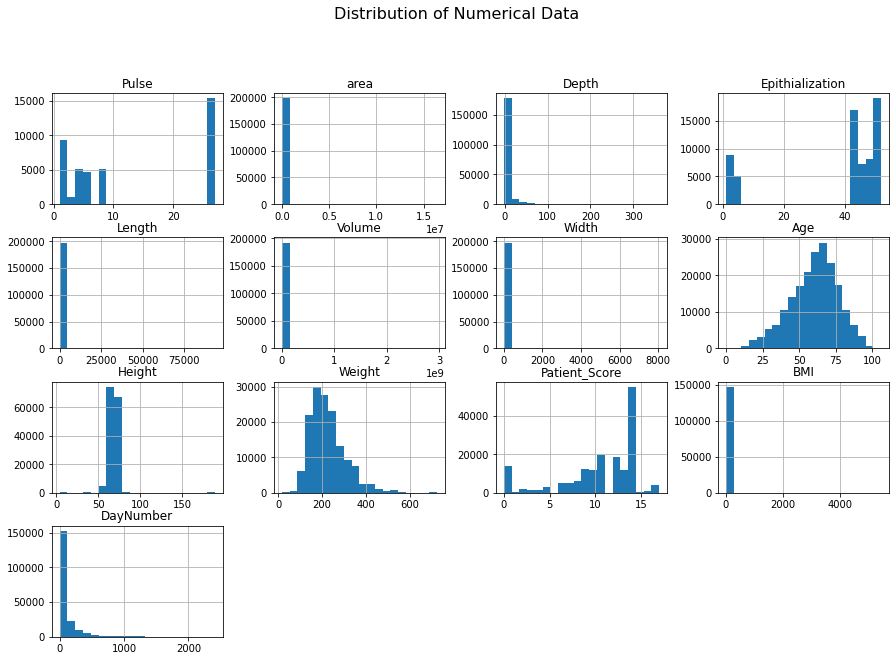

In [58]:
target_column = 'Wound_healing_status'

# Split the data into features (X) and the target variable (y)
X = big_df.drop([target_column], axis=1)

# Assuming X is your DataFrame with numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for each numerical column
X[numerical_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Data', y=1, fontsize=16)
plt.show()

## BMI column in this dataframe has outliers. Fixing it..

In [59]:
big_df.loc[big_df['BMI'] >= 1000, 'BMI'] /= 100
big_df["BMI"].sort_values(ascending=False).head(5000)

113973    95.1
113972    95.1
113968    95.1
113969    95.1
113970    95.1
          ... 
20821     57.2
20786     57.2
20787     57.2
20788     57.2
20734     57.2
Name: BMI, Length: 5000, dtype: float64

## measurement columns in this dataframe have outliers. Fixing it..

#### Removing the outlier rows where area, length, width are of really high values

In [60]:
# Function to remove outliers using IQR method for multiple columns
def remove_outliers_iqr_multi(df, columns):
    df_filtered = df.copy()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Remove rows with values outside the bounds for the current column
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

    return df_filtered

In [61]:
# Specify the columns for outlier removal
columns_to_remove_outliers = ['area', 'Length', 'Width', "Depth"]

# Apply the function to remove outliers from specified columns
df_no_outliers = remove_outliers_iqr_multi(big_df, columns_to_remove_outliers)

df_no_outliers["Length"]=abs(df_no_outliers["Length"])
df_no_outliers["Depth"]=abs(df_no_outliers["Depth"])

In [62]:
big_df=df_no_outliers

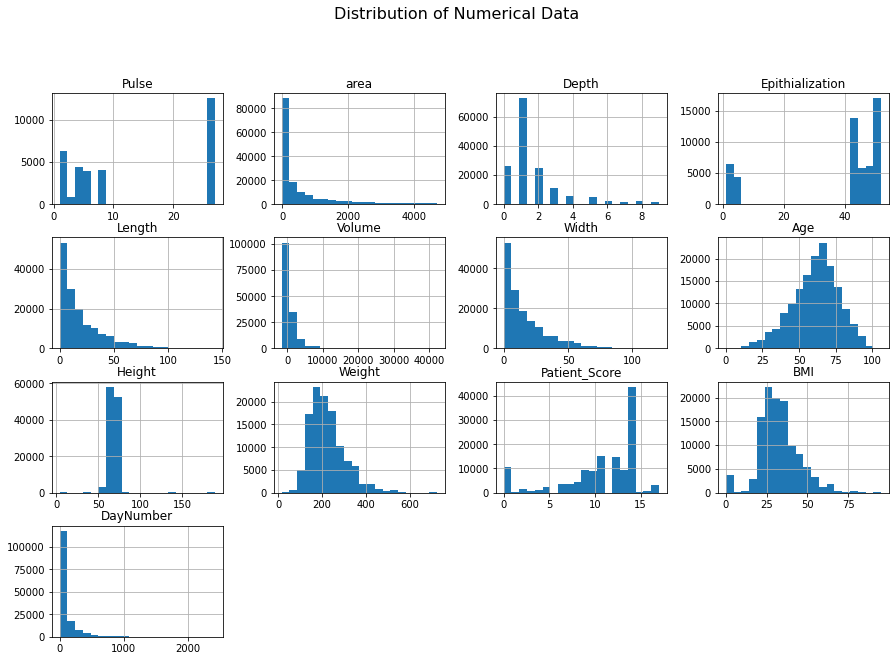

In [63]:
target_column = 'Wound_healing_status'

# Split the data into features (X) and the target variable (y)
X = big_df.drop([target_column], axis=1)

# Assuming X is your DataFrame with numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for each numerical column
X[numerical_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Data', y=1, fontsize=16)
plt.show()

In [65]:
big_df

,Pulse,AdiposeExposed,AdiposeNecrosisExposed,area,AtrophieBlanche,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,CapsuleNecrosisExposed,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip,Wound_healing_status,DayNumber
0,NaN,-1.0,1.0,33.60,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Unknown,1
1,NaN,-1.0,1.0,38.00,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Not healing,8
2,NaN,-1.0,1.0,40.28,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Not healing,15
3,NaN,-1.0,1.0,40.28,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Not healing,22
4,NaN,-1.0,1.0,30.00,1.0,1.0,1.0,1.0,1.0,1.0,...,quit in 2009,10000074_1,6.0,79.0,2.0,0.0,NaN,NaN,Grey,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197470,NaN,1.0,1.0,169.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Not healing,72
197471,NaN,1.0,1.0,130.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Grey,75
197472,NaN,1.0,1.0,110.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Not healing,80
197473,NaN,1.0,1.0,110.00,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,9996014_1,NaN,9.0,2.0,0.0,NaN,53708.0,Not healing,87


## Label encoding the categorical variables

In [ ]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in big_df.columns:
    # Check if the column is of object or categorical type
    if big_df[column].dtype == 'object':
        print(column)
        # Fit and transform the categorical column
        big_df[column] = label_encoder.fit_transform(big_df[column])

AdiposeExposed
AdiposeNecrosisExposed
AtrophieBlanche
BoneNecrosisExposed
BrawnyInduration
Callus
CapsuleExposed
CapsuleNecrosisExposed
color
CompCompression
CompDiet
CompDressing
CompExercise
CompHBOVisits
CompLimb
CompMedication
CompOffLoad
CompSmoking
CompWoundVisits
Crepitus
Cyanosis
Denuded
DryScaly
Ecchymosis
Edema
Erythema
Excoriation
ExposedBone
ExposedMuscle
ExposedTendon
Exudate
ExudateAmount
Fluctuance
Friable
GranulatedHyperGranulated
greygran
Hemosiderosis
hypergran
Induration
lowerExtremityEdema
Maceration
Moist
MuscleNecrosisExposed
NoMeasurableDepth
NonGranulationBiofilm
NonGranulationDessicated
NormalColor
NormalMoisture
normalTexture
NurseOnlyVisit
Odor
Pain
Pallor
pinkgran
Rash
redgran
RedGranulation
Rubor
Scarring
Shiny
sinustract
slough
SloughLessThan20
SSAbscess
SSCAndSPending
SSChangesInGranulationTissue
SSConfirmedLocal
SSConfirmedSystemic
SSDrainageDisproportionate
SSDrainageThick
SSFever
SSFoulWoundOdor
SSIncreasedEdema
SSInflammationExtendingToBone
SSMalaise


In [ ]:
big_df.to_csv("big_df_1.csv")

In [32]:
big_df=pd.read_csv("big_df_1.csv")
big_df=big_df.drop(["Unnamed: 0", "Patient_DocumentType", "DateAdded_woundassessment"],axis=1)
big_df

,Pulse,AdiposeExposed,AdiposeNecrosisExposed,area,AtrophieBlanche,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,CapsuleNecrosisExposed,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip,Wound_healing_status,DayNumber
0,NaN,0,2,33.60,2,2,2,2,2,2,...,1084,0,0,13,1,1,68,64,4,1
1,NaN,0,2,38.00,2,2,2,2,2,2,...,1084,0,0,13,1,1,68,64,3,8
2,NaN,0,2,40.28,2,2,2,2,2,2,...,1084,0,0,13,1,1,68,64,3,15
3,NaN,0,2,40.28,2,2,2,2,2,2,...,1084,0,0,13,1,1,68,64,3,22
4,NaN,0,2,30.00,2,2,2,2,2,2,...,1084,0,0,13,1,1,68,64,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152419,NaN,2,2,169.00,2,2,2,2,2,2,...,1217,22301,3,6,1,1,68,43,3,72
152420,NaN,2,2,130.00,2,2,2,2,2,2,...,1217,22301,3,6,1,1,68,43,0,75
152421,NaN,2,2,110.00,2,2,2,2,2,2,...,1217,22301,3,6,1,1,68,43,3,80
152422,NaN,2,2,110.00,2,2,2,2,2,2,...,1217,22301,3,6,1,1,68,43,3,87


In [33]:
categorical_features = ['Method', 'SmokingStatus', 'NonWoundDiagnosis', 'PatientGender','MedicareAdmission', 
                        'SmokingStatusText', 'WoundCondition', 'Location','AdmissionStatusCode', 'Religion',
                        'Pain', 'GranulationTexture','ExudateAmount', 'NormalColor', 'PalliativeCare', 
                        'Patient_RiskLevel', 'color', 'Exudate', 'Type', 'RedGranulation', 'Left_Right', 
                        'PatientDOB', 'WoundMargin', 'tunneling', 'RaceCodeList', 'PatientSelfCare', 
                        'PInsuranceZip', 'Bleeding', 'surroundingSkin', 'surroundingSkinColor', 'Anterior_Dorsal',
                        'CauseOfDeath', 'Proximal_Distal', 'woundstatus', 'ActiveWound', 'Inferior_Superior', 
                        'normalTexture', 'ResolvedRecurrence', 'Stage', 'slough', 'IsThisBurn', 'woundProgress', 
                        'Notes', 'CompCompression', 'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar', 
                        'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture','ResolvedRecurrence',
                        'Stage', 'IsThisBurn', 'CompCompression', 'SloughLessThan20', 'Anterior_Posterior', 'Odor',
                        'eschar','TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
                        'ResolvedRecurrence','FinalVisit_Healing_Status','PatientZIP', 'AllVisit_woundProgress', 
                        "Wound_healing_status", "AccidentType", "SInsuranceZip", "AdiposeExposed", "Rash",
                        "ethnicityCdcCode","CompDiet","Excoriation","AtrophieBlanche","Denuded", "Fluctuance",
                        "Moist", "NormalMoisture", "Shiny","Erythema","SSCAndSPending", "SSSignsAndSymptoms", 
                        "sinustract", "pinkgran", "greygran", "Crepitus", "Rubor", "SystematicInfection", "Callus",
                        "DryScaly", "ResultOfAccident", "Induration", "NoMeasurableDepth", "SSConfirmedLocal", 
                        "TendonNecrosisExposed", "Edema", "Friable", "BrawnyInduration", "Ecchymosis", 
                        "SSSystemicAntibiotics", "Ecchymosis", "ExposedMuscle", "Maceration", "Hemosiderosis", 
                        "redgran", "Scarring","AdiposeNecrosisExposed", "ExposedTendon","DebridementLevel",
                        "Temperature", "AdiposeExposed", "BoneNecrosisExposed", "CapsuleExposed", 
                        "CapsuleNecrosisExposed", "CompDressing", "CompExercise", "CompHBOVisits", "CompLimb",
                        "CompMedication", "CompOffLoad", "CompSmoking", "CompWoundVisits", "Cyanosis", 
                        "ExposedBone", "GranulatedHyperGranulated", "hypergran", "lowerExtremityEdema", 
                        "MuscleNecrosisExposed", "NonGranulationBiofilm", "NonGranulationDessicated", 
                        "NurseOnlyVisit", "Pallor", "SSAbscess", "SSChangesInGranulationTissue",
                        'SSConfirmedSystemic', 'SSDrainageDisproportionate', 'SSDrainageThick', 'SSFever',
                        'SSFoulWoundOdor', 'SSIncreasedEdema', 'SSInflammationExtendingToBone', 'SSMalaise', 
                        'SSNewOnset', 'SSOther', 'SSPocketing', 'SSPoorlyDefinedErythemalBorder', 
                        'SSTopicalAntibiotics', 'SSWarmthExtendingBeyondLocalPeriWound', 'SSWoundStalling', 
                        'JointNecrosisExposed', 'Bogginess', 'ExposedJoint', 'DryEscharFluctance', 
                        "acquiredAtFacility"]


# Iterate over columns
for col in big_df.columns:
    for prefix in categorical_features:
        if col.startswith(prefix) or col == prefix:
            big_df[col] = big_df[col].astype('category')

# Verify the changes
print(big_df.dtypes)

Pulse                                     float64
AdiposeExposed                           category
AdiposeNecrosisExposed                   category
area                                      float64
AtrophieBlanche                          category
BoneNecrosisExposed                      category
BrawnyInduration                         category
Callus                                   category
CapsuleExposed                           category
CapsuleNecrosisExposed                   category
color                                    category
CompCompression                          category
CompDiet                                 category
CompDressing                             category
CompExercise                             category
CompHBOVisits                            category
CompLimb                                 category
CompMedication                           category
CompOffLoad                              category
CompSmoking                              category


## See the important features according to RF, LightGBM and XGBoost

In [34]:
target_column = 'Wound_healing_status'

# Split the data into features (X) and the target variable (y)
X = big_df.drop([target_column], axis=1)
y = big_df[target_column]

# Create a Random Forest classifier
rf = XGBClassifier(enable_categorical=True, tree_method='hist')

# Fit the model
rf.fit(X, y)

# Get the feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort the feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Print the feature importances
print(feature_importances)


DayNumber                                0.179146
CompCompression                          0.128534
area                                     0.124224
woundProgress                            0.079102
Volume                                   0.070695
tunneling                                0.046669
PatientDOB                               0.039688
PatientZIP                               0.019787
Length                                   0.018863
Width                                    0.015257
SmokingStatusText                        0.014096
PalliativeCare                           0.008984
woundstatus                              0.007656
MedicareAdmission                        0.007509
Location                                 0.006846
Type                                     0.005694
Depth                                    0.005449
Stage                                    0.005231
Exudate                                  0.004793
Epithialization                          0.004734


In [35]:
feature_importances.index.tolist()

['DayNumber',
 'CompCompression',
 'area',
 'woundProgress',
 'Volume',
 'tunneling',
 'PatientDOB',
 'PatientZIP',
 'Length',
 'Width',
 'SmokingStatusText',
 'PalliativeCare',
 'woundstatus',
 'MedicareAdmission',
 'Location',
 'Type',
 'Depth',
 'Stage',
 'Exudate',
 'Epithialization',
 'ExudateAmount',
 'RedGranulation',
 'Fluctuance',
 'slough',
 'Religion',
 'redgran',
 'greygran',
 'Patient_Title',
 'AdmissionStatusCode',
 'NormalMoisture',
 'DateWoundHealed',
 'Pain',
 'NonWoundDiagnosis',
 'ethnicityCdcCode',
 'PatientGender',
 'WoundMargin',
 'color',
 'Rash',
 'eschar',
 'PatientSelfCare',
 'RaceCodeList',
 'Excoriation',
 'Friable',
 'NormalColor',
 'ExposedTendon',
 'AdmissionDate',
 'SSSystemicAntibiotics',
 'Moist',
 'Ecchymosis',
 'Admission_dateAdded',
 'GranulationTexture',
 'NoMeasurableDepth',
 'DateInactive',
 'Maceration',
 'firstAssessmentDate',
 'SSXRay',
 'Denuded',
 'Method',
 'DryScaly',
 'normalTexture',
 'SSConfirmedLocal',
 'CauseOfDeath',
 'Bleeding',
 'D

## Remove the less important features according to the model

In [36]:
# removal_DE_rf=['WoundRecurrence',
#  'GranulationQualityRed',
#  'ClusteredWound',
#  'Woundassessment_DocumentType',
#  'ErythemaLocCircumferential',
#  'PendingAmputationOnPresentation',
#  'NecroticTypeBlackEschar',
#  'NecroticTypeWetHydrated',
#  'NecroticTypeYellowSlough',
#  'TendernessOnPalpation',
#  'GranulationQualityHypertrophic',
#  'GranulationQualityPale',
#  'hypergran',
#  'GranulationQualityPink']    

# removal_DE_lightgbm=['CompMedication',
#  'CompExercise',
#  'CompDressing',
#  'CompHBOVisits',
#  'Cyanosis',
#  'ExposedBone',
#  'CompLimb',
#  'CompWoundVisits',
#  'CompSmoking',
#  'CompOffLoad',
#  'Patient_DocumentType',
#  'NurseOnlyVisit',
#  'WoundRecurrence',
#  'SSIncreasedEdema',
#  'SSTopicalAntibiotics',
#  'SSPoorlyDefinedErythemalBorder',
#  'SSPocketing',
#  'SSOther',
#  'SSNewOnset',
#  'SSMalaise',
#  'SSInflammationExtendingToBone',
#  'SSFoulWoundOdor',
#  'PendingAmputationOnPresentation',
#  'SSFever',
#  'SSDrainageThick',
#  'SSDrainageDisproportionate',
#  'SSConfirmedSystemic',
#  'SSChangesInGranulationTissue',
#  'SSAbscess',
#  'Pallor',
#  'SSWoundStalling',
#  'NonGranulationBiofilm',
#  'ErythemaLocCircumferential',
#  'NecroticTypeBlackEschar',
#  'GranulatedHyperGranulated',
#  'GranulationQualityPale',
#  'GranulationQualityPink',
#  'GranulationQualityRed',
#  'ClusteredWound',
#  'acquiredAtFacility',
#  'hypergran',
#  'Woundassessment_DocumentType',
#  'lowerExtremityEdema',
#  'NecroticTypeYellowSlough',
#  'GranulationQualityHypertrophic',
#  'DryEscharFluctance',
#  'NecroticTypeWetHydrated',
#  'Bogginess',
#  'TendernessOnPalpation',
#  'SSWarmthExtendingBeyondLocalPeriWound']

removal_DE_xgboost=['CompWoundVisits',
 'CapsuleNecrosisExposed',
 'CompMedication',
 'WoundRecurrence',
 'CompSmoking',
 'CompOffLoad',
 'CompLimb',
 'CompHBOVisits',
 'CompExercise',
 'AtrophieBlanche',
 'CompDiet',
 'CompDressing',
 'lowerExtremityEdema',
 'PendingAmputationOnPresentation',
 'GranulatedHyperGranulated',
 'SSFoulWoundOdor',
 'SSFever',
 'SSDrainageThick',
 'SSDrainageDisproportionate',
 'SSConfirmedSystemic',
 'SSChangesInGranulationTissue',
 'SSCAndSPending',
 'SSAbscess',
 'GranulationQualityPale',
 'Crepitus',
 'GranulationQualityPink',
 'GranulationQualityRed',
 'Pallor',
 'NurseOnlyVisit',
 'hypergran',
 'NonGranulationDessicated',
 'NonGranulationBiofilm',
 'MuscleNecrosisExposed',
 'SSIncreasedEdema',
 'SSInflammationExtendingToBone',
 'SSMalaise',
 'SSNewOnset',
 'ClusteredWound',
 'acquiredAtFacility',
 'NecroticTypeYellowSlough',
 'DryEscharFluctance',
 'NecroticTypeWetHydrated',
 'ExposedJoint',
 'Bogginess',
 'TendernessOnPalpation',
 'JointNecrosisExposed',
 'NecroticTypeBlackEschar',
 'ErythemaLocCircumferential',
 'ExposedBone',
 'SSWoundStalling',
 'SSWarmthExtendingBeyondLocalPeriWound',
 'SSPoorlyDefinedErythemalBorder',
 'SSPocketing',
 'SSOther',
 'GranulationQualityHypertrophic']


# removal_DE_rf=["GranulationQualityHypertrophic", "NecroticTypeYellowSlough", "TendernessOnPalpation", "NecroticTypeBlackEschar",
#                "ErythemaLocCircumferential", "PendingAmputationOnPresentation", "ClusteredWound", "WoundRecurrence",
#                "hypergran","GranulationQualityRed", "GranulationQualityPink", "NecroticTypeWetHydrated", 
#                "GranulationQualityPale"]    

# removal_DE_lightgbm=["SSChangesInGranulationTissue", "CompHBOVisits", "SSPoorlyDefinedErythemalBorder", "SSPocketing", 
#                      "CompWoundVisits", "SSOther", "SSNewOnset", "CompSmoking", "CompOffLoad", "CompMedication", "CompLimb", 
#                      "CompExercise", "SSWoundStalling", "CompDressing", "SSMalaise", "SSInflammationExtendingToBone", 
#                      "SSIncreasedEdema","SSFoulWoundOdor", "SSFever", "BoneNecrosisExposed", "SSDrainageThick", 
#                      "SSDrainageDisproportionate","Diabetes","Cyanosis","SSAbscess","lowerExtremityEdema","Pallor",
#                      "PendingAmputationOnPresentation","NonGranulationBiofilm","ClusteredWound","NonGranulationDessicated",
#                      "acquiredAtFacility","hypergran","WoundRecurrence","NurseOnlyVisit","NecroticTypeYellowSlough",
#                      "GranulationQualityRed","GranulationQualityPink","GranulationQualityPale","GranulatedHyperGranulated",
#                      "GranulationQualityHypertrophic","DryEscharFluctance","NecroticTypeWetHydrated","Bogginess",
#                      "TendernessOnPalpation","ExposedBone","NecroticTypeBlackEschar","ErythemaLocCircumferential",
#                      "SSWarmthExtendingBeyondLocalPeriWound"]

# removal_DE_xgboost=["hypergran","GranulationQualityPink","GranulationQualityRed","Diabetes","NonGranulationBiofilm",
#                     "lowerExtremityEdema","Patient_DocumentType","GranulationQualityPale","GranulatedHyperGranulated",
#                     "CompExercise","CapsuleNecrosisExposed","CompDressing","NonGranulationDessicated","CompSmoking",
#                     "CompOffLoad","CompMedication","CompLimb","CompHBOVisits","CompWoundVisits","Bogginess","NurseOnlyVisit",
#                     "Pallor","NecroticTypeWetHydrated","DryEscharFluctance","GranulationQualityHypertrophic",
#                     "NecroticTypeYellowSlough","NecroticTypeBlackEschar","ErythemaLocCircumferential","acquiredAtFacility",
#                     "ClusteredWound","SSWoundStalling","SSPoorlyDefinedErythemalBorder","SSPocketing","SSOther","SSNewOnset",
#                     "SSMalaise","SSInflammationExtendingToBone","PendingAmputationOnPresentation","SSIncreasedEdema",
#                     "SSFoulWoundOdor","SSFever","WoundRecurrence","SSDrainageThick","SSDrainageDisproportionate",
#                     "SSChangesInGranulationTissue","TendernessOnPalpation","SSAbscess","SSWarmthExtendingBeyondLocalPeriWound"]

In [37]:
#common_elements = set(removal_DE_rf) & set(removal_DE_lightgbm) & set(removal_DE_xgboost)
common_elements = set(removal_DE_xgboost)


len(common_elements)

55

In [38]:
all_elements = set(removal_DE_xgboost)

len(all_elements)

55

In [39]:
list(all_elements)

['CompWoundVisits',
 'CompDressing',
 'GranulationQualityPale',
 'ExposedBone',
 'GranulationQualityHypertrophic',
 'DryEscharFluctance',
 'PendingAmputationOnPresentation',
 'Pallor',
 'SSOther',
 'CompMedication',
 'SSFever',
 'AtrophieBlanche',
 'GranulatedHyperGranulated',
 'acquiredAtFacility',
 'SSMalaise',
 'CompDiet',
 'NecroticTypeYellowSlough',
 'hypergran',
 'GranulationQualityPink',
 'NecroticTypeWetHydrated',
 'SSInflammationExtendingToBone',
 'CompLimb',
 'SSWoundStalling',
 'SSChangesInGranulationTissue',
 'ExposedJoint',
 'CompExercise',
 'CompHBOVisits',
 'Crepitus',
 'SSWarmthExtendingBeyondLocalPeriWound',
 'CapsuleNecrosisExposed',
 'WoundRecurrence',
 'SSIncreasedEdema',
 'CompOffLoad',
 'TendernessOnPalpation',
 'SSConfirmedSystemic',
 'GranulationQualityRed',
 'JointNecrosisExposed',
 'SSNewOnset',
 'MuscleNecrosisExposed',
 'CompSmoking',
 'SSPoorlyDefinedErythemalBorder',
 'SSCAndSPending',
 'NonGranulationDessicated',
 'SSDrainageThick',
 'NonGranulationBiofil

## So let's remove these data elements which less important according to feature importance for rf, lightgbm and xgboost

In [40]:
big_df_1=big_df.drop(list(all_elements), axis=1)
big_df_1

,Pulse,AdiposeExposed,AdiposeNecrosisExposed,area,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,color,CompCompression,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip,Wound_healing_status,DayNumber
0,NaN,0,2,33.60,2,2,2,2,12,1,...,1084,0,0,13,1,1,68,64,4,1
1,NaN,0,2,38.00,2,2,2,2,12,1,...,1084,0,0,13,1,1,68,64,3,8
2,NaN,0,2,40.28,2,2,2,2,2,1,...,1084,0,0,13,1,1,68,64,3,15
3,NaN,0,2,40.28,2,2,2,2,2,1,...,1084,0,0,13,1,1,68,64,3,22
4,NaN,0,2,30.00,2,2,2,2,2,1,...,1084,0,0,13,1,1,68,64,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152419,NaN,2,2,169.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,3,72
152420,NaN,2,2,130.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,0,75
152421,NaN,2,2,110.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,3,80
152422,NaN,2,2,110.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,3,87


In [25]:
# 3 = not healing
# 0 = grey
# 2 = healing
# 4 = unknown
# 1 = healed

## Removing highly correlated features from the dataframe

In [41]:
# Example dataset (replace this with your actual dataset)
data = big_df_1

# Custom correlation function to handle NaN values
def custom_correlation(x, y, method):
    valid_values = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_values]
    y_valid = y[valid_values]
    
    if method == 'pearson':
        # Handle NaN values for Pearson correlation
        mask = np.isfinite(x_valid) & np.isfinite(y_valid)
        correlation_result = pointbiserialr(x_valid[mask], y_valid[mask])
    elif method == 'pointbiserial':
        correlation_result = pointbiserialr(x_valid, y_valid)
    else:
        raise ValueError(f"Unsupported correlation method: {method}")
    
    return correlation_result

# Create an empty dictionary to store correlation results
correlation_results = {}

# Iterate through numerical columns
for numerical_var in data.select_dtypes(include=['float64', 'int64']).columns:
    # Iterate through all columns
    for column in data.columns:
        # Skip the numerical variable itself
        if column == numerical_var:
            continue
        
        # Determine data types
        data_type_numerical = data[numerical_var].dtype
        data_type_column = data[column].dtype
        
        # Apply the appropriate correlation method based on data types
        if data_type_numerical in ['float64', 'int64'] and data_type_column in ['float64', 'int64']:
            # Both variables are numerical - use Pearson correlation
            correlation_result = custom_correlation(data[numerical_var], data[column], 'pearson')
        elif data_type_numerical in ['float64', 'int64'] and data_type_column == ('object' or 'category'):
            # Numerical variable and categorical variable - use point-biserial correlation
            # Convert binary categorical data to numeric
            data_numeric = pd.Categorical(data[column]).codes
            correlation_result = custom_correlation(data[numerical_var], data_numeric, 'pointbiserial')
        # Add other cases as needed
        else:
            # Other combinations - skip or handle accordingly
            continue
        
        # Store the correlation result
        key = f"{numerical_var}_vs_{column}"
        correlation_results[key] = correlation_result

# Print the results
for key, result in correlation_results.items():
    print(f"Correlation {key}:\n{result}\n")


Correlation Pulse_vs_area:
SignificanceResult(statistic=0.01180123920320859, pvalue=0.03411858631058264)

Correlation Pulse_vs_Depth:
SignificanceResult(statistic=0.03734267819450079, pvalue=1.9974735737024023e-11)

Correlation Pulse_vs_Epithialization:
SignificanceResult(statistic=0.8285706370732655, pvalue=0.0)

Correlation Pulse_vs_Length:
SignificanceResult(statistic=-0.008650883288280765, pvalue=0.12040846738425456)

Correlation Pulse_vs_Volume:
SignificanceResult(statistic=0.052542585806981616, pvalue=3.947614849039395e-21)

Correlation Pulse_vs_Width:
SignificanceResult(statistic=-0.0004365988663821347, pvalue=0.9375261538384034)

Correlation Pulse_vs_DateAcquired:
SignificanceResult(statistic=-0.061808022490676386, pvalue=1.16538272951758e-28)

Correlation Pulse_vs_DateInactive:
SignificanceResult(statistic=-0.002191397882409514, pvalue=0.6940190861487101)

Correlation Pulse_vs_DateOfAccident:
SignificanceResult(statistic=0.03325672419476176, pvalue=2.3436539096348148e-09)

Cor

In [42]:
# target_column='Wound_healing_status'

# # Set the threshold for correlation
# threshold = 0.90
# #0.8 should be thres

# #wilconson rank_sum correlation
# #tau as coefficient

# # List to store reduced DataFrames
# dfs_reduced = []


df=big_df_1

# # Calculate correlation matrix
# #corr_matrix = df.drop(target_column, axis=1).corr()
# correlation_matrix = df.corr()

# # Step 2: Identify Highly Correlated Features
# threshold = 0.95
# highly_correlated_pairs = []

# for i in range(len(df.columns)):
#     for j in range(i + 1, len(df.columns)):
#         if abs(correlation_matrix.iloc[i, j]) > threshold:
#             highly_correlated_pairs.append((df.columns[i], df.columns[j]))

# # Step 3 and 4: Evaluate Feature Importance and Drop Less Important Features
# for feature1, feature2 in highly_correlated_pairs:
#     # Create a subset DataFrame with the correlated features and the target feature
#     if all(feature in df.columns for feature in [feature1, feature2]):
#         subset_df = pd.concat([df[[feature1, feature2]],df[target_column]],axis=1)

#         # Prepare data for Random Forest
#         X = subset_df[[feature1, feature2]]
#         y = subset_df[target_column]

#         # Fit Random Forest regressor
#         rf = RandomForestRegressor()
#         rf.fit(X, y)

#         # Print feature importance
#         print(f"\nFeature Importance for {feature1}: {rf.feature_importances_[0]}")
#         print(f"Feature Importance for {feature2}: {rf.feature_importances_[1]}")

#         # Drop the less important feature
#         if rf.feature_importances_[0] < rf.feature_importances_[1]:
#             df.drop(feature1, axis=1, inplace=True)
#             print("Dropping",feature1,"\n")
#         else:
#             df.drop(feature2, axis=1, inplace=True)
#             print("Dropping",feature2,"\n")

# # Display the modified DataFrame
# display(df)

# #     # Append the reduced DataFrame to the list
# #     dfs_reduced.append(df)

# # # Concatenate the reduced DataFrames
# # df_reduced = pd.concat(dfs_reduced, axis=1)

# # # Display the final reduced DataFrame
# # df_reduced


# #scaled log transform


In [43]:
df_filtered=df
df_filtered

,Pulse,AdiposeExposed,AdiposeNecrosisExposed,area,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,color,CompCompression,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip,Wound_healing_status,DayNumber
0,NaN,0,2,33.60,2,2,2,2,12,1,...,1084,0,0,13,1,1,68,64,4,1
1,NaN,0,2,38.00,2,2,2,2,12,1,...,1084,0,0,13,1,1,68,64,3,8
2,NaN,0,2,40.28,2,2,2,2,2,1,...,1084,0,0,13,1,1,68,64,3,15
3,NaN,0,2,40.28,2,2,2,2,2,1,...,1084,0,0,13,1,1,68,64,3,22
4,NaN,0,2,30.00,2,2,2,2,2,1,...,1084,0,0,13,1,1,68,64,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152419,NaN,2,2,169.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,3,72
152420,NaN,2,2,130.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,0,75
152421,NaN,2,2,110.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,3,80
152422,NaN,2,2,110.00,2,2,2,2,8,0,...,1217,22301,3,6,1,1,68,43,3,87


In [44]:
X = df.drop([target_column], axis=1)
y = df[target_column]

# Fit Random Forest regressor
rf = XGBClassifier(enable_categorical=True, tree_method='hist')
rf.fit(X, y)

for key, result in correlation_results.items():
    #print(key)
    # Split the string into two parts
    split_parts = key.split('_vs_')
    # Display the result
    
    
    if round(result[0],4)>0.8:
        
        print(split_parts)
        print("Correlation Coeff:",round(result[0],4))
        feature1=split_parts[0]
        feature2=split_parts[1]

        columns_to_check = [feature1, feature2]

        # Iterate through the columns and check if each column is present
        if set(columns_to_check).issubset(df.columns):
            print("Both columns are present in the DataFrame.")

            # Print feature importance
            print(f"\nFeature Importance for {feature1}: {pd.Series(rf.feature_importances_, index=X.columns)[feature1]}")
            print(f"Feature Importance for {feature2}: {pd.Series(rf.feature_importances_, index=X.columns)[feature2]}")

            feature_1_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature1]
            feature_2_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature2]

            # Drop the less important feature
            if feature_1_importance < feature_2_importance:
                df.drop(feature1, axis=1, inplace=True)
                print("Dropping",feature1,"\n")
            else:
                df.drop(feature2, axis=1, inplace=True)
                print("Dropping",feature2,"\n")

    # Display the modified DataFrame
display(df)

['Pulse', 'Epithialization']
Correlation Coeff: 0.8286
Both columns are present in the DataFrame.

Feature Importance for Pulse: 0.0018012799555435777
Feature Importance for Epithialization: 0.004734412766993046
Dropping Pulse 

['area', 'Length']
Correlation Coeff: 0.823
Both columns are present in the DataFrame.

Feature Importance for area: 0.12422390282154083
Feature Importance for Length: 0.018863491714000702
Dropping Length 

['area', 'Width']
Correlation Coeff: 0.814
Both columns are present in the DataFrame.

Feature Importance for area: 0.12422390282154083
Feature Importance for Width: 0.01525727566331625
Dropping Width 

['Epithialization', 'Pulse']
Correlation Coeff: 0.8286
['Length', 'area']
Correlation Coeff: 0.823
['Width', 'area']
Correlation Coeff: 0.814
['firstAssessmentDate', 'DateAdded_wound']
Correlation Coeff: 0.8437
Both columns are present in the DataFrame.

Feature Importance for firstAssessmentDate: 0.0021862767171114683
Feature Importance for DateAdded_wound: 

,AdiposeExposed,AdiposeNecrosisExposed,area,BoneNecrosisExposed,BrawnyInduration,Callus,CapsuleExposed,color,CompCompression,Cyanosis,...,SmokingStatusText,PatientIDWoundNumber,DebridementLevel,Method,Bleeding,IsThisBurn,SInsuranceZip,PInsuranceZip,Wound_healing_status,DayNumber
0,0,2,33.60,2,2,2,2,12,1,2,...,1084,0,0,13,1,1,68,64,4,1
1,0,2,38.00,2,2,2,2,12,1,2,...,1084,0,0,13,1,1,68,64,3,8
2,0,2,40.28,2,2,2,2,2,1,2,...,1084,0,0,13,1,1,68,64,3,15
3,0,2,40.28,2,2,2,2,2,1,2,...,1084,0,0,13,1,1,68,64,3,22
4,0,2,30.00,2,2,2,2,2,1,2,...,1084,0,0,13,1,1,68,64,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152419,2,2,169.00,2,2,2,2,8,0,2,...,1217,22301,3,6,1,1,68,43,3,72
152420,2,2,130.00,2,2,2,2,8,0,2,...,1217,22301,3,6,1,1,68,43,0,75
152421,2,2,110.00,2,2,2,2,8,0,2,...,1217,22301,3,6,1,1,68,43,3,80
152422,2,2,110.00,2,2,2,2,8,0,2,...,1217,22301,3,6,1,1,68,43,3,87


In [45]:
# target_column='Wound_healing_status'


# df=big_df_1

# # Calculate correlation matrix
# #corr_matrix = df.drop(target_column, axis=1).corr()
# correlation_matrix = df.corr()

# # Step 2: Identify Highly Correlated Features
# threshold = 0.95
# highly_correlated_pairs = []

# for i in range(len(df.columns)):
#     for j in range(i + 1, len(df.columns)):
#         if abs(correlation_matrix.iloc[i, j]) > threshold:
#             highly_correlated_pairs.append((df.columns[i], df.columns[j]))
            
# # Prepare data for Random Forest
# X = df.drop([target_column, 'Wound_healing_percentage'], axis=1)
# y = df[target_column]

# # Fit Random Forest regressor
# rf = LGBMClassifier()
# rf.fit(X, y)

# # Step 3 and 4: Evaluate Feature Importance and Drop Less Important Features
# for feature1, feature2 in highly_correlated_pairs:
#     # List of columns you want to check
#     columns_to_check = [feature1, feature2]

#     # Iterate through the columns and check if each column is present
#     if set(columns_to_check).issubset(df.columns):
#         print("Both columns are present in the DataFrame.")
        
#         # Print feature importance
#         print(f"\nFeature Importance for {feature1}: {pd.Series(rf.feature_importances_, index=X.columns)[feature1]}")
#         print(f"Feature Importance for {feature2}: {pd.Series(rf.feature_importances_, index=X.columns)[feature2]}")

#         feature_1_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature1]
#         feature_2_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature2]

#         # Drop the less important feature
#         if feature_1_importance < feature_2_importance:
#             df.drop(feature1, axis=1, inplace=True)
#             print("Dropping",feature1,"\n")
#         else:
#             df.drop(feature2, axis=1, inplace=True)
#             print("Dropping",feature2,"\n")

# # Display the modified DataFrame
# display(df)

# #     # Append the reduced DataFrame to the list
# #     dfs_reduced.append(df)

# # # Concatenate the reduced DataFrames
# # df_reduced = pd.concat(dfs_reduced, axis=1)

# # # Display the final reduced DataFrame
# # df_reduced


In [46]:
# target_column='Wound_healing_status'


# df=big_df_1

# # Calculate correlation matrix
# #corr_matrix = df.drop(target_column, axis=1).corr()
# correlation_matrix = df.corr()

# # Step 2: Identify Highly Correlated Features
# threshold = 0.95
# highly_correlated_pairs = []

# for i in range(len(df.columns)):
#     for j in range(i + 1, len(df.columns)):
#         if abs(correlation_matrix.iloc[i, j]) > threshold:
#             highly_correlated_pairs.append((df.columns[i], df.columns[j]))

# # Step 3 and 4: Evaluate Feature Importance and Drop Less Important Features
# for feature1, feature2 in highly_correlated_pairs:
#     # Create a subset DataFrame with the correlated features and the target feature
#     if all(feature in df.columns for feature in [feature1, feature2]):
#         subset_df = pd.concat([df[[feature1, feature2]],df[target_column]],axis=1)

#         # Prepare data for Random Forest
#         X = subset_df[[feature1, feature2]]
#         y = subset_df[target_column]

#         # Fit Random Forest regressor
#         rf = XGBClassifier()
#         rf.fit(X, y)

#         # Print feature importance
#         print(f"\nFeature Importance for {feature1}: {rf.feature_importances_[0]}")
#         print(f"Feature Importance for {feature2}: {rf.feature_importances_[1]}")

#         # Drop the less important feature
#         if rf.feature_importances_[0] < rf.feature_importances_[1]:
#             df.drop(feature1, axis=1, inplace=True)
#             print("Dropping",feature1,"\n")
#         else:
#             df.drop(feature2, axis=1, inplace=True)
#             print("Dropping",feature2,"\n")

# # Display the modified DataFrame
# display(df)

# #     # Append the reduced DataFrame to the list
# #     dfs_reduced.append(df)

# # # Concatenate the reduced DataFrames
# # df_reduced = pd.concat(dfs_reduced, axis=1)

# # # Display the final reduced DataFrame
# # df_reduced


In [47]:
df["Wound_healing_status"].unique()

[4, 3, 0, 2, 1]
Categories (5, int64): [0, 1, 2, 3, 4]

In [48]:
df.columns.tolist()

['AdiposeExposed',
 'AdiposeNecrosisExposed',
 'area',
 'BoneNecrosisExposed',
 'BrawnyInduration',
 'Callus',
 'CapsuleExposed',
 'color',
 'CompCompression',
 'Cyanosis',
 'Denuded',
 'Depth',
 'DryScaly',
 'Ecchymosis',
 'Edema',
 'Epithialization',
 'Erythema',
 'Excoriation',
 'ExposedMuscle',
 'ExposedTendon',
 'Exudate',
 'ExudateAmount',
 'Fluctuance',
 'Friable',
 'greygran',
 'Hemosiderosis',
 'Induration',
 'Maceration',
 'Moist',
 'NoMeasurableDepth',
 'NormalColor',
 'NormalMoisture',
 'normalTexture',
 'Odor',
 'Pain',
 'pinkgran',
 'Rash',
 'redgran',
 'RedGranulation',
 'Rubor',
 'Scarring',
 'Shiny',
 'sinustract',
 'slough',
 'SloughLessThan20',
 'SSConfirmedLocal',
 'SSSignsAndSymptoms',
 'SSSystemicAntibiotics',
 'SSTopicalAntibiotics',
 'SSXRay',
 'Stage',
 'surroundingSkin',
 'surroundingSkinColor',
 'SystematicInfection',
 'Temperature',
 'TendonNecrosisExposed',
 'tunneling',
 'TunnelingOrUndermining',
 'Volume',
 'woundProgress',
 'GranulationTexture',
 'WoundM

In [49]:
df.to_csv("df_filtered.csv")